In [2]:
import shap
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#print(X_display)
print(y_test[0:5])

[False  True False False False]


In [3]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
eval_set = [(X_test, y_test)]
lgb=LGBMClassifier(n_estimators=997, learning_rate=0.05, max_depth=3,colsample_bytree=0.842,
                     min_child_weight=2,subsample=0.8, )
model=lgb.fit(X_train,y_train,verbose=False)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.44%


In [4]:
#select = np.random.choice(len(X_test),20,replace=False)
select = range(20)
features = X_test.iloc[select]
#print(features.index)
features_display = X_display.iloc[features.index]
#print(features_display)

In [5]:
import numpy as np

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features) 
print(explainer.expected_value)
print(np.array(shap_values).shape)
print(np.array(shap_interaction_values).shape)

-2.4868130324455318
(2, 20, 12)
(20, 12, 12)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


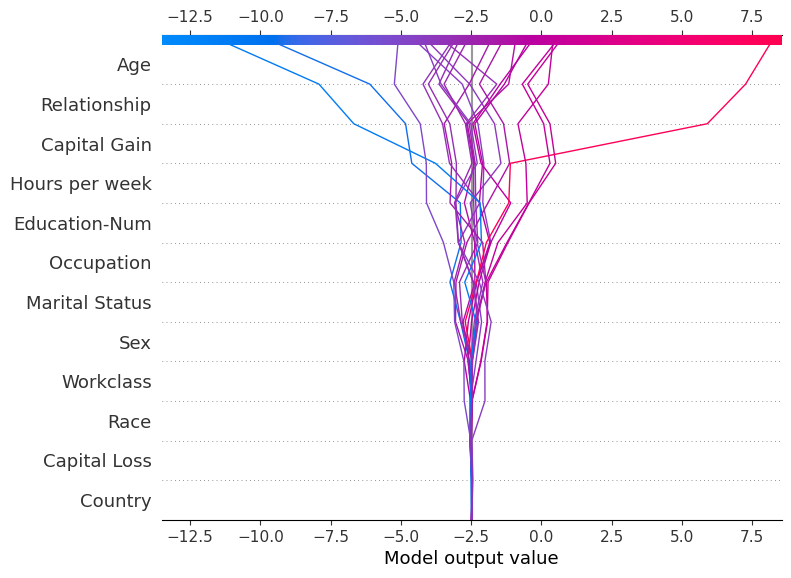

In [6]:
shap.decision_plot(explainer.expected_value, shap_values[1], features_display)

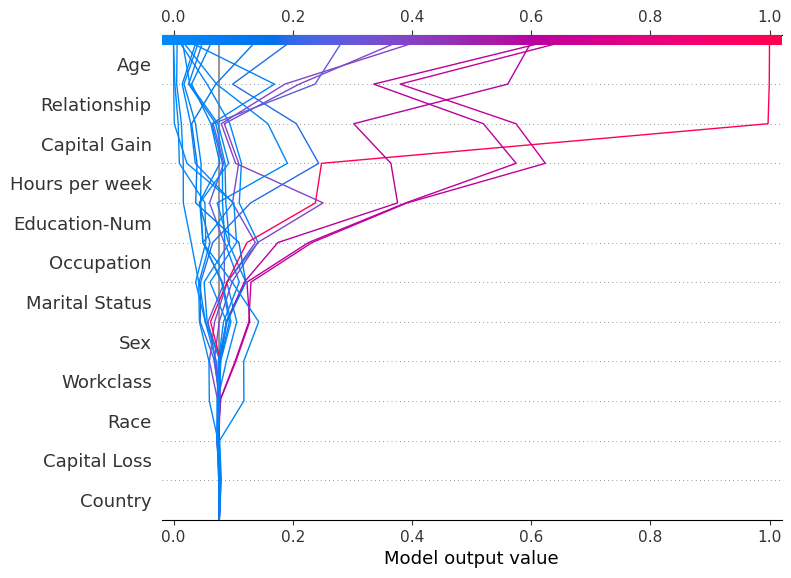

In [7]:
shap.decision_plot(explainer.expected_value, shap_values[1], features_display, link='logit')

[False False False False False False False False False False False False
  True False False False False False False False]


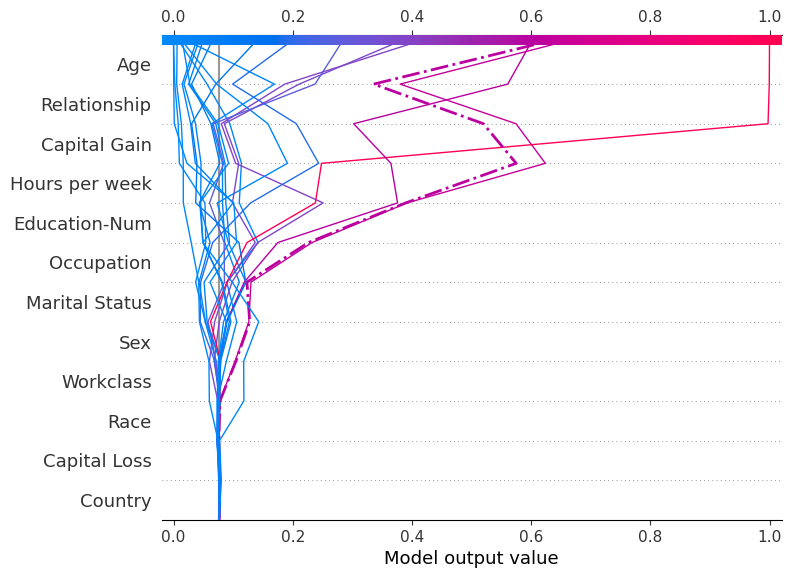

In [8]:
expected_value=explainer.expected_value
y_pred = model.predict(features)
#y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != y_test[select]
print(misclassified)
shap.decision_plot(expected_value, shap_values[1], features_display, link='logit', highlight=12)

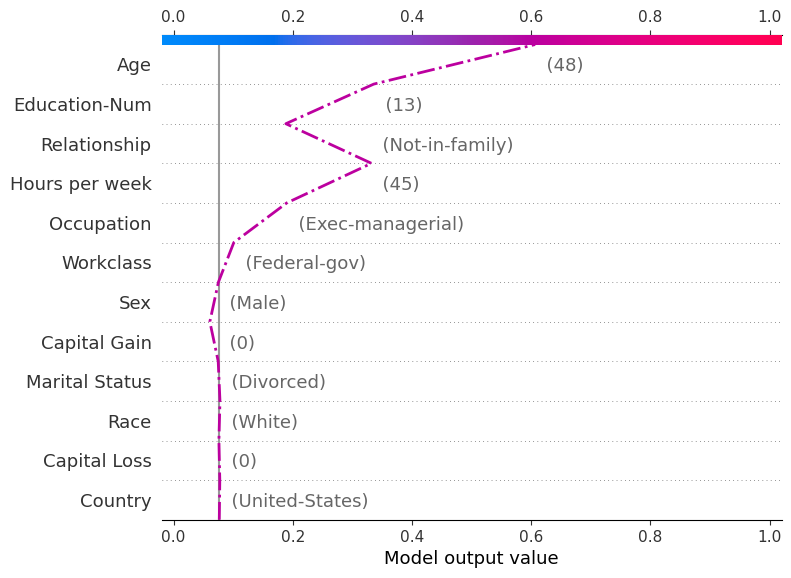

In [9]:
shap.decision_plot(expected_value, shap_values[1][misclassified], features_display[misclassified],
                   link='logit', highlight=0)

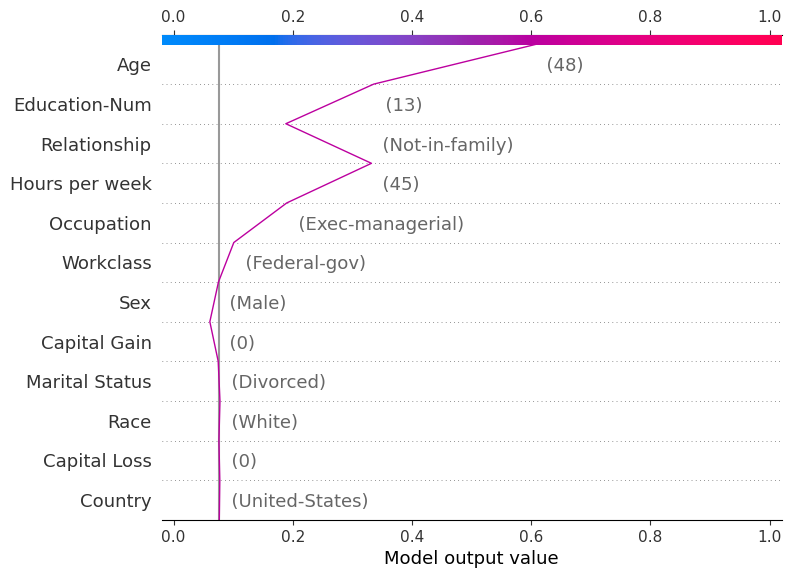

In [10]:
shap.decision_plot(expected_value, shap_values[1][12], features_display[misclassified],
                   link='logit')

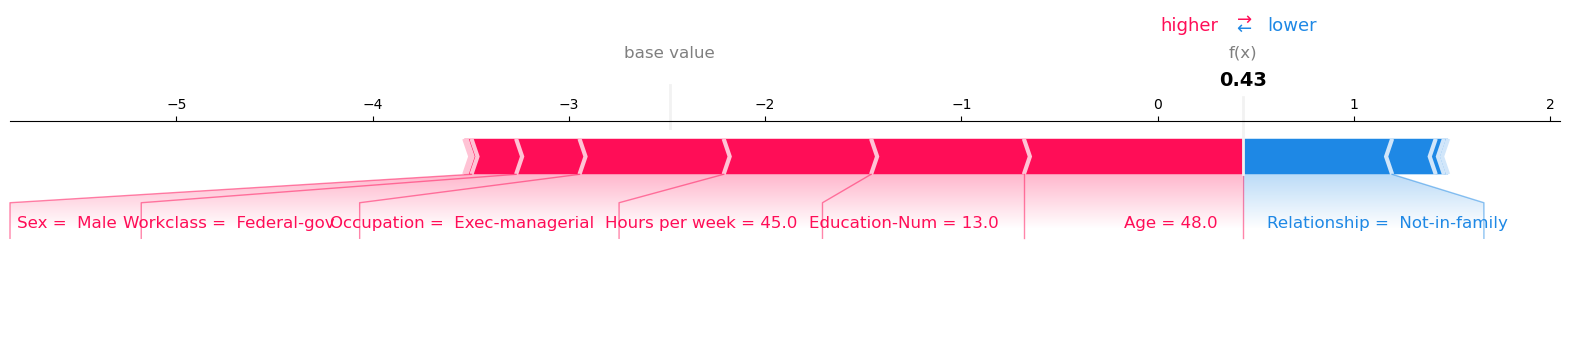

In [11]:
shap.force_plot(expected_value, shap_values[1][12], features_display[misclassified],
               matplotlib=True)

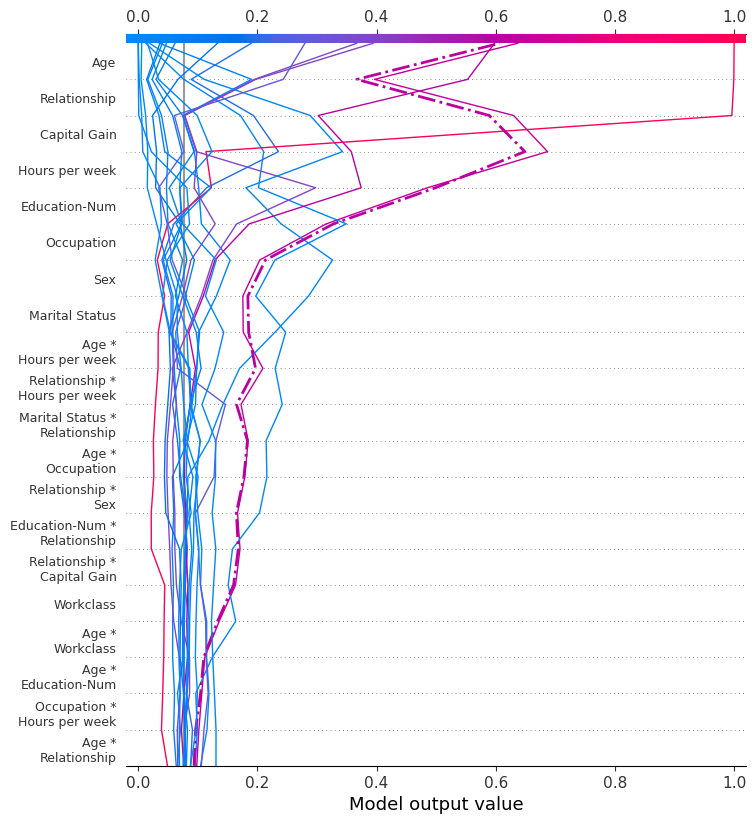

In [12]:
shap.decision_plot(expected_value, shap_interaction_values, features_display, highlight=misclassified,
                   link='logit')

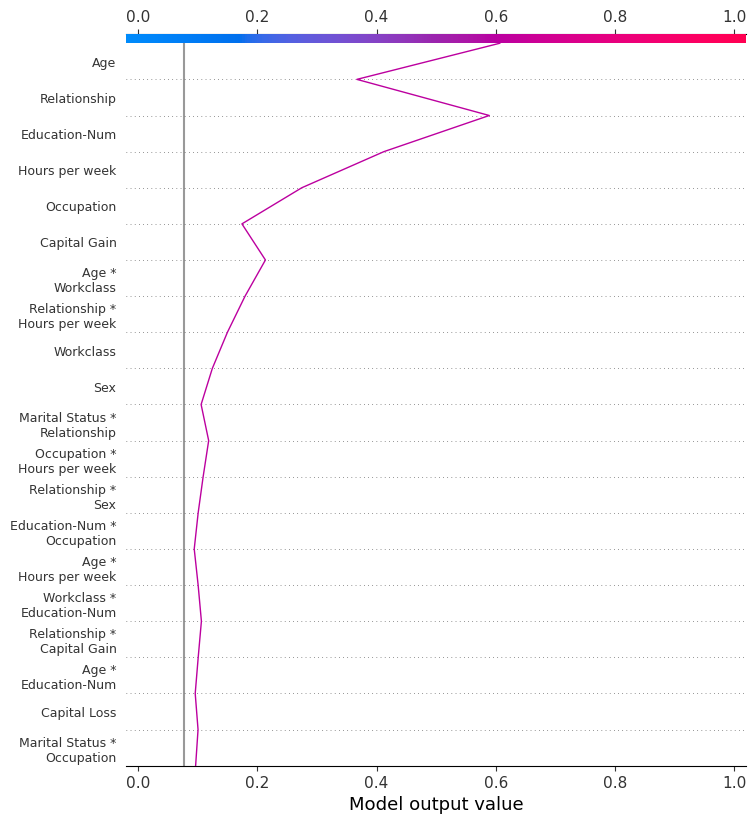

In [13]:
shap.decision_plot(expected_value, shap_interaction_values[misclassified], features_display[misclassified],
                   link='logit')

In [14]:
idx = 25
X_display.iloc[idx]
rep=np.repeat(idx, 6)
print(rep)
ex=X.iloc[rep]
print(ex)

[25 25 25 25 25 25]
     Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
25  56.0          2           13.0               2          13             4   
25  56.0          2           13.0               2          13             4   
25  56.0          2           13.0               2          13             4   
25  56.0          2           13.0               2          13             4   
25  56.0          2           13.0               2          13             4   
25  56.0          2           13.0               2          13             4   

    Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
25     4    1           0.0           0.0            40.0       39  
25     4    1           0.0           0.0            40.0       39  
25     4    1           0.0           0.0            40.0       39  
25     4    1           0.0           0.0            40.0       39  
25     4    1           0.0           0.0            40.0       39  
25   

In [15]:
idx = 25
rg = range(0, 10000, 100)
R = X.iloc[np.repeat(idx, len(rg))].reset_index(drop=True)
print(R.shape)
R['Capital Gain'] = rg

hypothetical_shap_values = explainer.shap_values(R)[1]
hypothetical_predictions = expected_value + hypothetical_shap_values.sum(axis=1)
hypothetical_predictions = 1 / (1 + np.exp(-hypothetical_predictions))

(100, 12)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


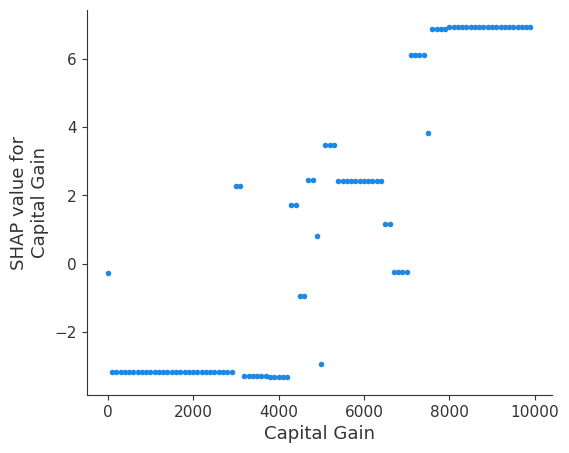

In [16]:
shap.dependence_plot('Capital Gain', hypothetical_shap_values, R, interaction_index=None)

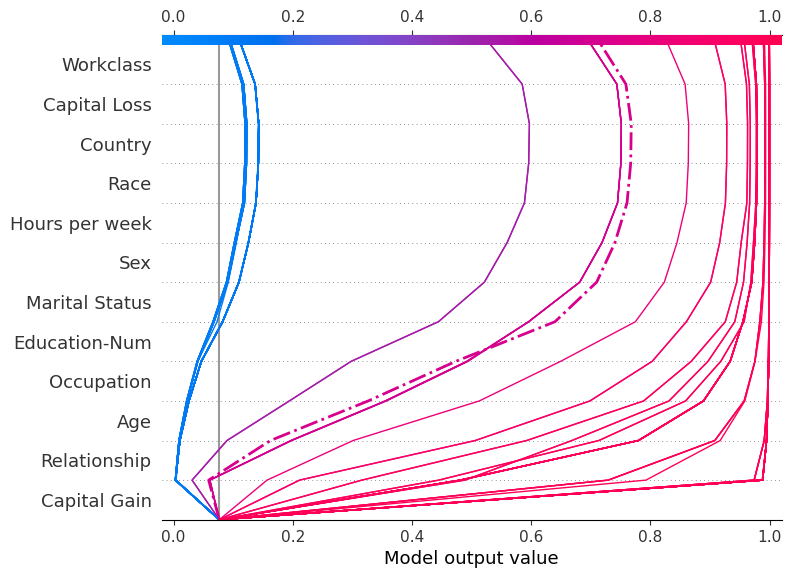

In [17]:
shap.decision_plot(expected_value, hypothetical_shap_values, R, link='logit', 
                   feature_order='hclust', highlight=0)

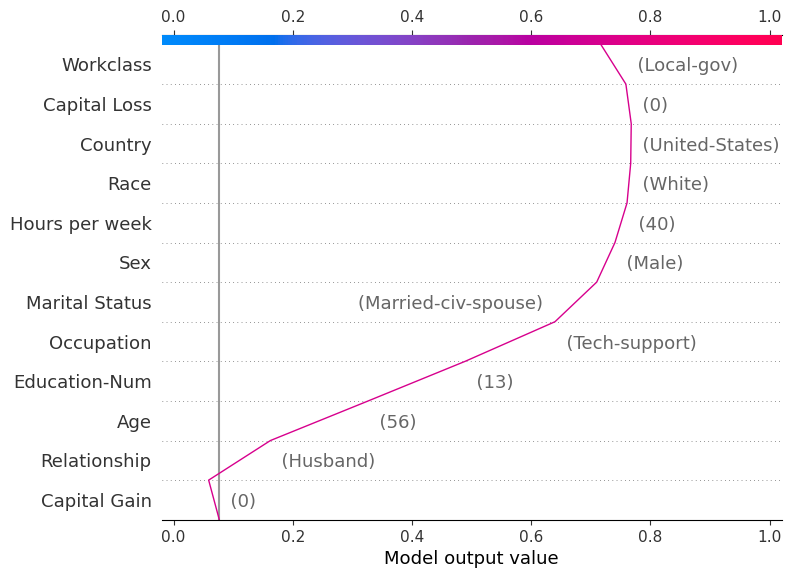

In [18]:
# The feature ordering was determined via 'hclust' on the synthetic data set. We specify the order here manually so
# the following two plots match up.
feature_idx = [8, 5, 0, 2, 4, 3, 7, 10, 6, 11, 9, 1]
shap.decision_plot(expected_value, hypothetical_shap_values[0], X_display.iloc[idx], feature_order=feature_idx,
                   link='logit')

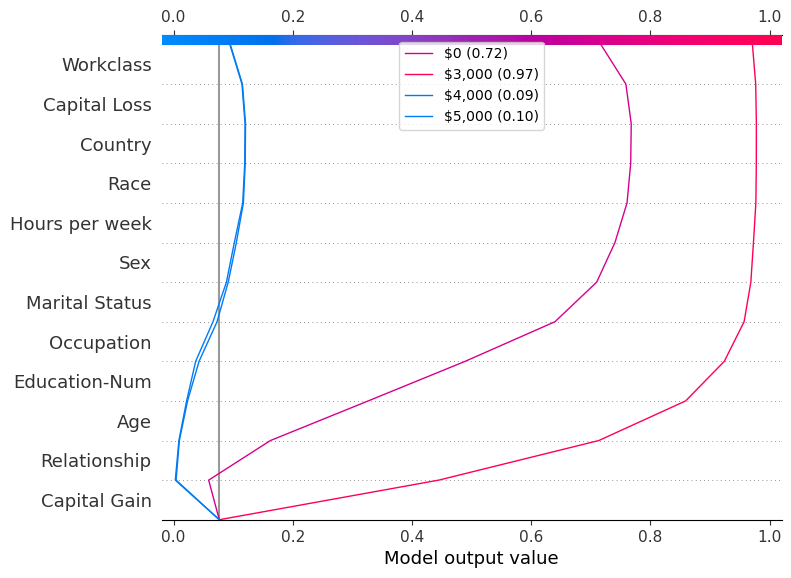

In [19]:
def legend_labels(idx):
    return [f'\${i * 100:,} ({hypothetical_predictions[i]:.2f})' for i in idx]

show_idx = [0, 30, 40, 50]
shap.decision_plot(expected_value, hypothetical_shap_values[show_idx], X, feature_order=feature_idx,
                   link='logit', legend_labels=legend_labels(show_idx), legend_location='upper center')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


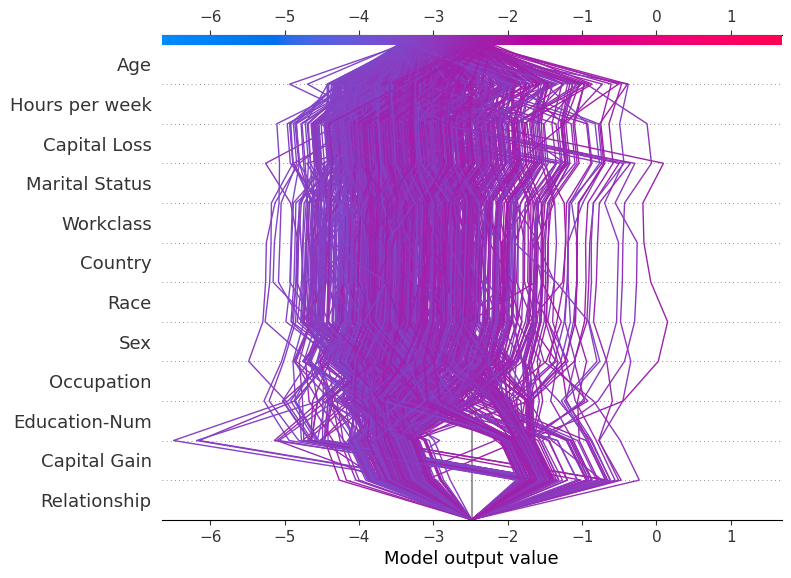

In [20]:
y_pred = model.predict_proba(X_test) # Get predictions on the probability scale.
T = X_test[(y_pred[:,1] >= 0.03) & (y_pred[:,1] <= 0.1)]
sh = explainer.shap_values(T)[1]
r = shap.decision_plot(expected_value, sh, T, feature_order='hclust', return_objects=True)

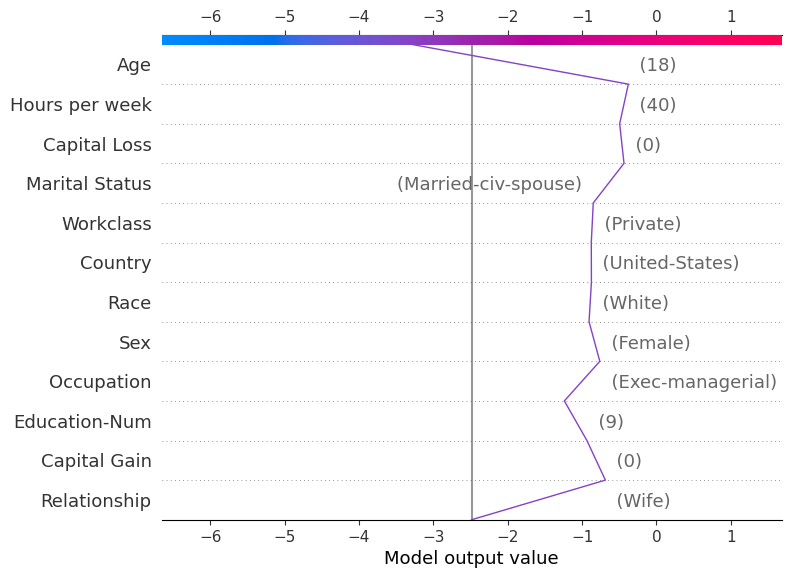

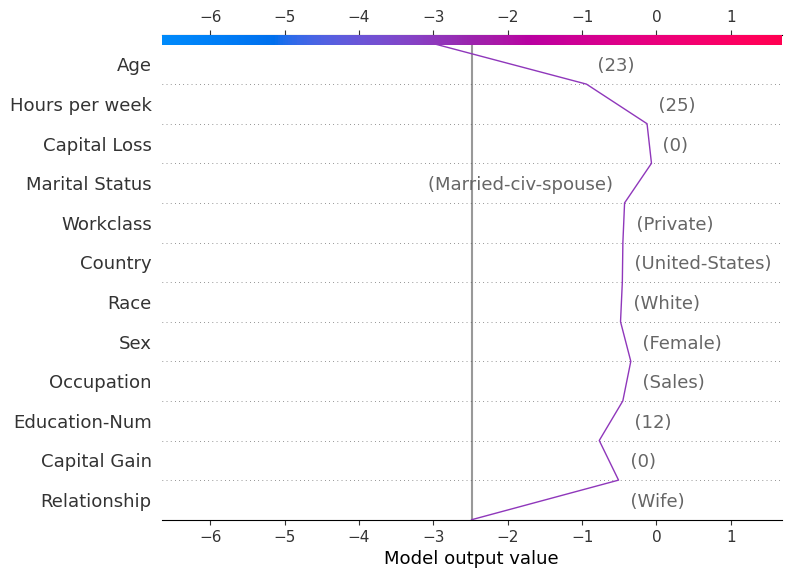

In [21]:
# Find the two observations with the most negative 'Age' SHAP values.
idx = np.argpartition(sh[:, T.columns.get_loc('Age')], 2)[0:2]

# Plot the observations individually with their corresponding feature values. The plots use the same feature order
# as the original plot.
for i in idx:
    shap.decision_plot(expected_value, sh[i], X_display.loc[T.index[i]], feature_order=r.feature_idx, xlim=r.xlim)

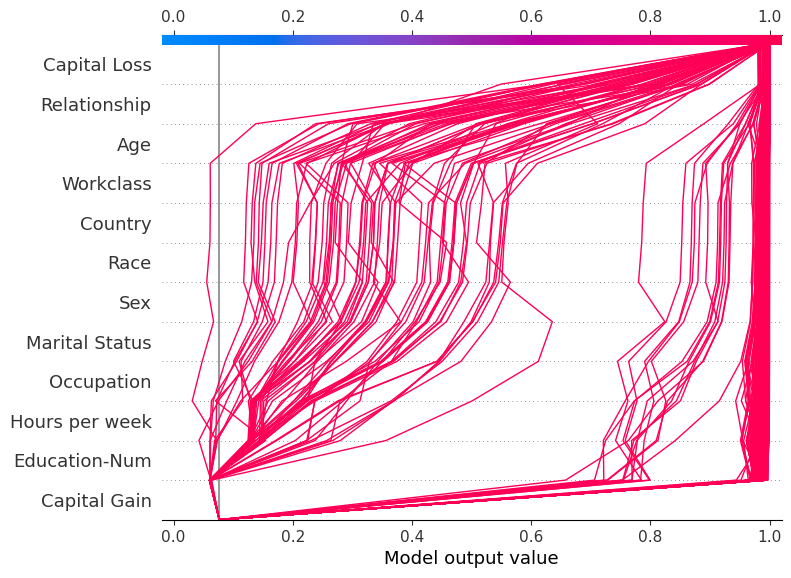

In [23]:
y_pred = model.predict_proba(X_test)  # Get predictions on the probability scale.
T = X_test[y_pred[:,1] >= 0.98]
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
sh = explainer.shap_values(T)[1]
shap.decision_plot(expected_value, sh, T, feature_order='hclust', link='logit')

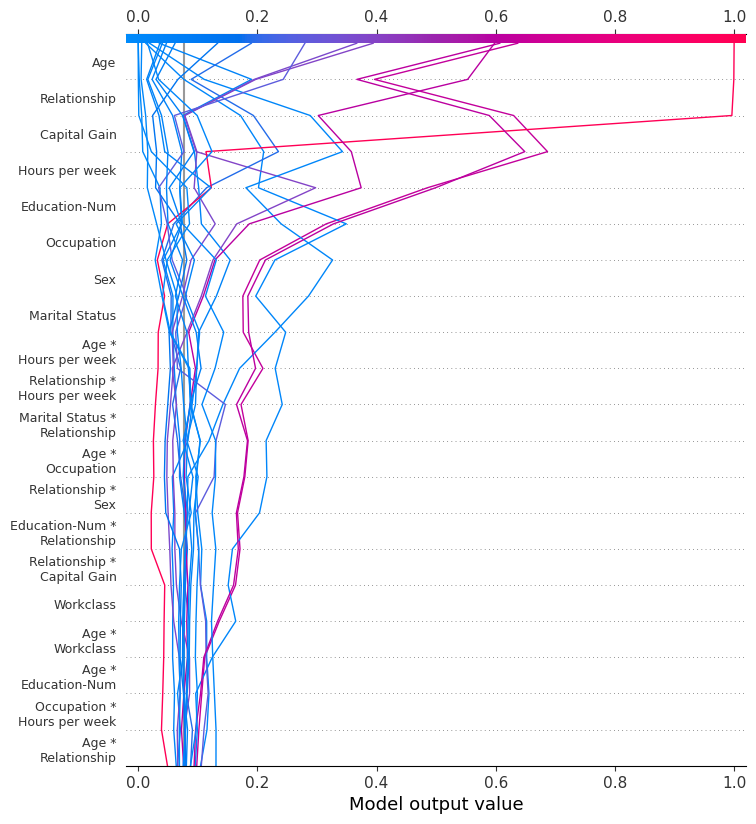

In [24]:
shap.decision_plot(expected_value, shap_interaction_values, features, link='logit')

In [25]:
base_values = [None] * 5
print(base_values)

[None, None, None, None, None]


In [27]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
eval_set = [(X_test, y_test)]

models=[]

cat=CatBoostClassifier(n_estimators=500,verbose=0)
cat.fit(X_train,y_train, eval_set=eval_set, early_stopping_rounds=50 )
models.append(cat)

y_pred_cat = cat.predict(X_test)
print(y_pred_cat[:5])
for i,val in enumerate(y_pred_cat):
    if val=='True':
        y_pred_cat[i]=True
    else:
        y_pred_cat[i]=False

accuracy = sum(y_test==y_pred_cat)/6513
print("Accuracy: %.2f%%" % (accuracy * 100.0))

['False' 'True' 'False' 'False' 'False']
Accuracy: 87.21%


In [5]:
lin=LogisticRegression(max_iter=10000)
lin.fit(X_train,y_train)
models.append(lin)

y_pred_lin=lin.predict(X_test)
for i,val in enumerate(y_pred_lin):
    if val=='True':
        y_pred_lin[i]=True
    else:
        y_pred_lin[i]=False
accuracy = sum(y_test==y_pred_lin)/6513
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 76.02%


In [6]:
def model_selection(model,X_train,y_train):
    m=model(n_estimators=500)
    m.fit(X_train,y_train, eval_set=eval_set,early_stopping_rounds=50, verbose=False)
    y_pred=m.predict(X_test)
    accuracy = sum(y_test==y_pred)/6513
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    models.append(m)    

In [7]:
model_selection(LGBMClassifier,X_train,y_train)
model_selection(XGBClassifier,X_train,y_train)

Accuracy: 87.46%
[18:50:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Accuracy: 87.30%


In [8]:
print(models)

[<catboost.core.CatBoostClassifier object at 0x0000026F0271F4F0>, LogisticRegression(max_iter=10000), LGBMClassifier(n_estimators=500), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)]


In [10]:
import numpy as np

explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X.iloc[[27]])
print(explainer.expected_value)
print(np.array(shap_values).shape)
predict=cat.predict_proba(X.iloc[[27]])[0,1]
print(predict)
print(y[27])

-2.436259357790677
(1, 12)
0.6016975345399977
True


In [10]:
explainer_lin = shap.KernelExplainer(lin.predict,X_train)
shap_values_lin = explainer_lin.shap_values(X.iloc[[27]])
print(explainer_lin.expected_value)
print(np.array(shap_values_lin).shape)
predict=lin.predict_proba(X.iloc[[27]])[0,1]
print(predict)

X does not have valid feature names, but LogisticRegression was fitted with feature names
Using 26048 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


0.18058968058968056
(1, 12)
0.4542090087014647


In [11]:
xx=[None]*4
xx


[None, None, None, None]

In [12]:
def get_ensemble_shap_values(models,X_test, X):
    base_values = [None] * 4
    shap_values = [None] * 4
    predictions = [None] * 4
    for i, m in enumerate(models):
        if i==0:
            explainer = shap.TreeExplainer(m)
            shap_values_1 = explainer.shap_values(X)
            base_values[i]=explainer.expected_value
            shap_values[i]=shap_values_1
            predictions[i]=m.predict_proba(X)[0,1]
        elif i==1:
            explainer_lin=shap.KernelExplainer(m.predict,X_test)
            shap_values_lin=explainer_lin.shap_values(X)
            base_values[i]=explainer_lin.expected_value
            shap_values[i]=shap_values_lin
            predictions[i]=m.predict_proba(X)[0,1]
        elif i==2:
            a = m.predict(X, pred_contrib=True)  # `pred_contrib=True` returns SHAP values for LightGBM
            base_values[i] = a[0, -1]  # The last column in the matrix is the base value.
            shap_values[i] = a[:, 0:-1]
            predictions[i] = 1 / (1 + np.exp(-a.sum(axis=1)[0]))  # Predictions as probabilities
        else:
            explainer_xgb = shap.TreeExplainer(m)
            shap_values_xgb = explainer_xgb.shap_values(X)
            base_values[i]=explainer_xgb.expected_value
            shap_values[i]=shap_values_xgb
            predictions[i]=1 / (1 + np.exp(-(explainer_xgb.expected_value+shap_values_xgb.sum(axis=1)[0])))
            
    return base_values, shap_values, predictions

In [13]:
ensemble_base_values, ensemble_shap_values, ensemble_predictions \
= get_ensemble_shap_values(models, X_train, X.iloc[[27]])

print(np.array(ensemble_base_values).shape)
print(np.array(ensemble_shap_values).shape)
print(np.array(ensemble_predictions))

X does not have valid feature names, but LogisticRegression was fitted with feature names
Using 26048 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(4,)
(4, 1, 12)
[0.60169753 0.45420901 0.63962547 0.51268103]


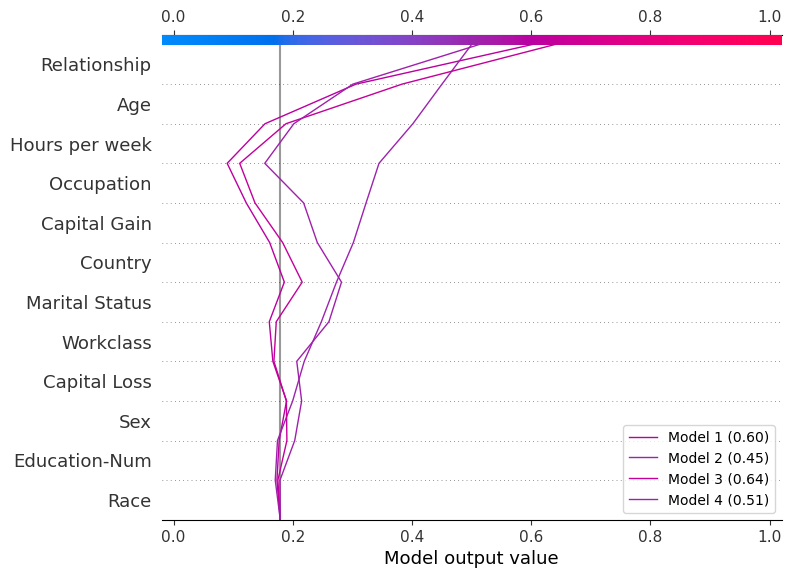

In [14]:
# Create labels for legend

labels=[f'Model {i + 1} ({ensemble_predictions[i].round(2):.2f})' for i in range(4)]
# Plot
shap.multioutput_decision_plot(ensemble_base_values, ensemble_shap_values, row_index=0,
                               feature_names=X.columns.to_list(), link='logit', 
                               legend_labels=labels, legend_location='lower right')

In [64]:
import pandas as pd
import numpy as np
df = pd.read_csv('log2.csv')
y = df.Action.copy()
X = df.drop('Action',axis=1)
print(np.unique(y))
print(X.info())

['allow' 'deny' 'drop' 'reset-both']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Source Port           65532 non-null  int64
 1   Destination Port      65532 non-null  int64
 2   NAT Source Port       65532 non-null  int64
 3   NAT Destination Port  65532 non-null  int64
 4   Bytes                 65532 non-null  int64
 5   Bytes Sent            65532 non-null  int64
 6   Bytes Received        65532 non-null  int64
 7   Packets               65532 non-null  int64
 8   Elapsed Time (sec)    65532 non-null  int64
 9   pkts_sent             65532 non-null  int64
 10  pkts_received         65532 non-null  int64
dtypes: int64(11)
memory usage: 5.5 MB
None


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
cls = RandomForestClassifier(max_depth=2, random_state=0)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [66]:
y.value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [70]:
#!pip install shap
import shap
explainer_tree = shap.TreeExplainer(cls)
log_shap_values = explainer_tree.shap_values(X_test.iloc[0:300])
log_interaction_values = explainer_tree.shap_interaction_values(X_test.iloc[0:300]) 
log_expected=list(explainer_tree.expected_value)
print(np.array(log_shap_values).shape)
print(np.array(log_interaction_values).shape)
print(log_expected)

(4, 300, 11)
(4, 300, 11, 11)
[0.5748786343567519, 0.22804919733870463, 0.19615536430039265, 0.0009168040041506438]


In [122]:
class_count = len(log_expected)
log_feature_names=list(X.columns)
log_predictions=cls.predict_proba(X_test.iloc[0:300])

In [123]:
def class_labels(row_index):
    return [f'Class {i + 1} ({log_predictions[row_index, i].round(2):.2f})' for i in range(class_count)]

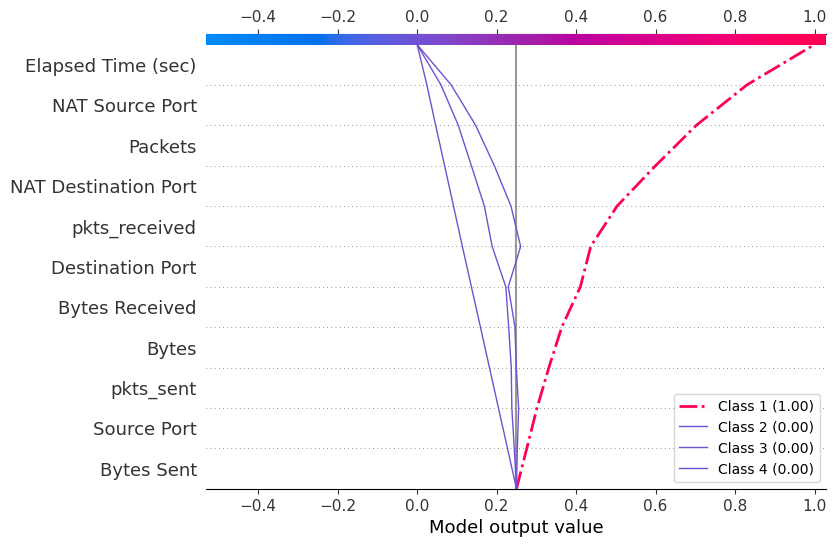

In [125]:
row_index = 2
shap.multioutput_decision_plot(log_expected, log_shap_values,
                               row_index=row_index,
                               feature_names=log_feature_names,
                               highlight=[np.argmax(log_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right')

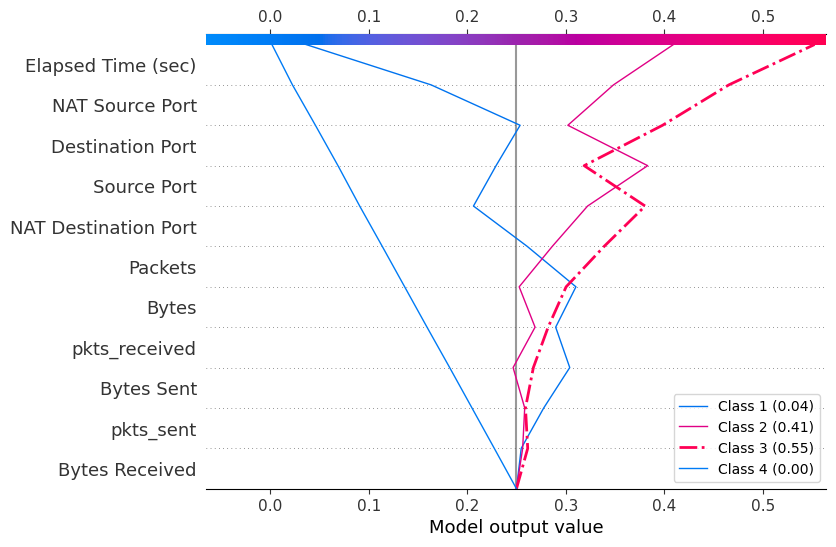

In [126]:
row_index = 3
shap.multioutput_decision_plot(log_expected, log_shap_values,
                               row_index=row_index,
                               feature_names=log_feature_names,
                               highlight=[np.argmax(log_predictions[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right')